In [1]:
# importing libraries
import Phonon_Number as pn
import parameters as params

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from IPython.display import clear_output
from scipy.io import savemat, loadmat
from scipy.optimize import minimize
from scipy.special import gamma as gamma_function

In [2]:
def calculate_error(parameters):
    '''
    Returns absolute log error between phonon(t) and fit(t)    
    '''
    decay_rate, beta = parameters

    fit = pn.stretched_exponential(time, decay_rate, beta)
    error = np.sum(np.abs(np.log10(phonon) - np.log10(fit)))/len(phonon)
    
    return error

def save_data():
    '''
    Compile all the variables into a .mat file and save it
    '''
    QD_phonon_decay_thermal = {'T2' : T2,
                               'T1' : T1,
                               'pump' : pump,
                               'nth' : nth,
                               'g' : g,
                               'temperature' : temperature,
                               'gamma' : gamma,
                               'omega_m' : omega_m,
                               'N' : N,
                               'decay_rate' : decay_rate,
                               'best_fit_error': best_fit_error,
                               'beta_array': beta_array,
                               'phonon_ss': phonon_ss,
                               'phonon_number_array': phonon_number_array,
                               'best_fit_array': best_fit_array,
                               'average_error':average_error,
                               't_final_array': t_final_array
                              }
            
    savemat("QD_phonon_decay_thermal.mat", QD_phonon_decay_thermal)

In [3]:
'''
Parameters as in the manuscript
'''

# Import parameters
omega_m, g, T1, gamma, temperature, nth = params.QD_params()

N = 15              # size of the fock state basis
dephasing = 0       # in GHz

print('nth = ', nth)

initial_state = pn.calculate_initial_state(N, nth)
print('initial phonons = ', pn.calculate_phonon_number(initial_state, N))

data_points = 30
T2 = np.logspace(-1,1,data_points)*g
pump = np.logspace(-1,1,data_points)*g

# Defining arrays to store data
decay_rate = np.zeros((len(pump), len(T2)))
beta_array = np.zeros((len(pump), len(T2)))

best_fit_error = np.zeros((len(pump), len(T2)))
best_fit_array = []
average_error = np.zeros((len(pump), len(T2)))

nth =  1.0233109863949017
initial phonons =  1.022767383258408


In [4]:
'''
Import data from datasets
'''

# Import data
QD_phonon_decay_thermal = loadmat('./data files/QD_phonon_decay_thermal_updated.mat')
phonon_number_array = QD_phonon_decay_thermal['phonon_number_array']
t_final_array = QD_phonon_decay_thermal['t_final_array']
phonon_ss = QD_phonon_decay_thermal['phonon_ss']

### Calculate and store phonon number as a function of time

In [ ]:
'''
Iterate over T2 and pump arrays to calculate phonon_number(t) and t_final and store in respective arrays
'''

for i in range(len(pump)):
    for j in range(len(T2)):
            
        if(i%10 == 0 or j%10 == 0):    # saving data in between
            save_data()
            
        if(t_final_array[i,j] == 0):    # run if the index is not initialized
        
            t_final = max(3000/(T2[j]), 500)       # time for simulation for QD case (in ns)
        
            loop_again = True               # check for looping again
            counter = 0                     # count the number of loops for one set of values of pump and T2
            print('index at: (', i,j, ')') 
            
            while(loop_again):    # loop until steadystate is verified by the function check_ss()
                counter = counter + 1
                
                # Define Hamiltonian and collapse operators
                Hamiltonian, collapse_ops = pn.QD_system(g, pump, T2, T1, gamma, dephasing, nth, N)
                
                # Create time array
                time = np.linspace(0, t_final, 5000)

                # Simulate the system to calculate phonon(t)
                phonon = pn.master_eq_solver(Hamiltonian, initial_state, time, collapse_ops, N)
                
                # Calculate the steady state phonon number
                phonon_ss[i,j] = pn.steady_state_phonon(Hamiltonian, collapse_ops, N)
                
                # check for steadystate
                check = pn.check_ss(phonon)
                
                if(check):              # if true, store data
                    phonon_number_array[i,j,:] = phonon
                    t_final_array[i,j] = t_final
                    
                    loop_again = False  # break the while loop
                else:                   # else, increase time for simulation and run again
                    t_final = t_final*3
                
            print('counter = ', counter)
            
            # plot fits and formatting
            plt.figure()
            plt.title('counter = {}, index: (', i,j,')'.format(counter), fontsize = 12)
            plt.semilogy(time, phonon, label = 'phonon #', linewidth = 4)
            fig = plt.gcf()
            fig.set_size_inches((10, 5), forward=False)
            plt.xticks(fontsize = 12)
            plt.yticks(fontsize = 12)
            plt.savefig('./QD_phonon_decay_thermal_updated/Plot({}, {})'.format(i,j))
            plt.close()

save_data()

### Fitting extended exponential function to phonon number

In [8]:
'''
Calculating the best fist and subsequently the corresponding decay rate and beta values.

- Using scipy.optimize.minmize for fitting
- Initial condition for an index tuple is the decay rate of the previous index; decay_rate_init[i,j] = decay_rate[i,j-1].
-- When j = 0; decay_rate_init[i,j] = decay_rate[i-1,0]
-- When i = 0 = j; decay_rate_init[0,0] = 10**-2

'''

for i in range(len(pump)):
    
    if(i == 0):
        decay_rate_init = 10**-2
    else:
        decay_rate_init = decay_rate[i-1, 0]
    
    for j in range(len(T2)):
        
        print('(',i,j,'); oldie error = ', average_error[i,j])
        
        # Fitting directly to data
        phonon = phonon_number_array[i,j]
        time = np.linspace(0, t_final_array[i,j], 5000)
        
        # Calculating the value of the variable index
        index = pn.find_index(phonon, phonon_ss[i,j])
        
        # Shrink the arrays for fitting
        time = time[:index]
        phonon = phonon[:index]
        
        # Calculate best fit using scipy.minimize
        result_best_fit = minimize(calculate_error, x0 = [decay_rate_init, 1], bounds = [(10**-4, 10**2), (0, 1)], tol = 10**-10)
        
        # Substitute values
        decay_rate[i,j] = result_best_fit.x[0]
        beta_array[i,j] = result_best_fit.x[1]
        best_fit_error[i,j] = result_best_fit.fun
        
        # Create best fit array using best fit parameters and store
        best_fit = pn.stretched_exponential(time, decay_rate[i,j], beta_array[i,j], phonon_ss[i,j], nth)
        best_fit_array.append(best_fit)
        
        # Calculate average error
        average_error[i,j] = pn.calculate_average_error(best_fit, phonon)

        print('average error = ', average_error[i,j])
        
        counter = 'post_processing'
        
        # Re-initialize the initial condition for decay_rate for scipy.minimize
        decay_rate_init = decay_rate[i,j]
        
        plt.figure()
        plt.title('decay_rate = {:1f}, counter = {}, average_error = {:1f}, beta = {:1f}'\
                  .format(decay_rate[i,j], counter, average_error[i,j], beta_array[i,j]), fontsize = 10)
        plt.semilogy(np.linspace(0, t_final_array[i,j], 5000), phonon_number_array[i,j], label = 'phonon #', linewidth = 4)
        plt.semilogy(time, best_fit, label = 'phonon fit', linewidth = 3, linestyle = '--', color = '#ff7f0e')
        legend = plt.legend(fontsize = 20, frameon = False)
        plt.xticks(fontsize = 10)
        plt.yticks(fontsize = 10)
        fig = plt.gcf()
        fig.set_size_inches((10, 5), forward=False)
        plt.savefig('./QD_phonon_decay_thermal_updated/Plot({}, {})'.format(i,j))
        plt.close()

        print('')

decay_rate = decay_rate*beta_array/gamma_function(1/beta_array)
save_data()

( 0 0 ); oldie error =  0.0
average error =  0.003728729241505596

( 0 1 ); oldie error =  0.0
average error =  0.002135371369385714

( 0 2 ); oldie error =  0.0
average error =  0.0024123975833943386

( 0 3 ); oldie error =  0.0
average error =  0.0027031498799827054

( 0 4 ); oldie error =  0.0
average error =  0.0030015640038073403

( 0 5 ); oldie error =  0.0
average error =  0.0033141678682147573

( 0 6 ); oldie error =  0.0
average error =  0.003639525561929133

( 0 7 ); oldie error =  0.0
average error =  0.003996106618023688

( 0 8 ); oldie error =  0.0
average error =  0.004383527941396546

( 0 9 ); oldie error =  0.0
average error =  0.004613603804737912

( 0 10 ); oldie error =  0.0
average error =  0.004341616299744608

( 0 11 ); oldie error =  0.0
average error =  0.004081993897180664

( 0 12 ); oldie error =  0.0
average error =  0.0038432874518940976

( 0 13 ); oldie error =  0.0
average error =  0.003631428498491973

( 0 14 ); oldie error =  0.0
average error =  0.00691

average error =  0.004719062580251616

( 4 5 ); oldie error =  0.0
average error =  0.005236040178155938

( 4 6 ); oldie error =  0.0
average error =  0.00579510986192371

( 4 7 ); oldie error =  0.0
average error =  0.006382524619069489

( 4 8 ); oldie error =  0.0
average error =  0.006060348227498001

( 4 9 ); oldie error =  0.0
average error =  0.0057763091830715756

( 4 10 ); oldie error =  0.0
average error =  0.005491722999849505

( 4 11 ); oldie error =  0.0
average error =  0.0052391581977477425

( 4 12 ); oldie error =  0.0
average error =  0.004955727593810689

( 4 13 ); oldie error =  0.0
average error =  0.004744811733861935

( 4 14 ); oldie error =  0.0
average error =  0.004481597709919016

( 4 15 ); oldie error =  0.0
average error =  0.004223642458866379

( 4 16 ); oldie error =  0.0
average error =  0.003967896722020817

( 4 17 ); oldie error =  0.0
average error =  0.0037329644898348767

( 4 18 ); oldie error =  0.0
average error =  0.003417948711086198

( 4 19 ); ol

average error =  0.004356360991960817

( 8 17 ); oldie error =  0.0
average error =  0.003844012974758645

( 8 18 ); oldie error =  0.0
average error =  0.0034281576133321644

( 8 19 ); oldie error =  0.0
average error =  0.0030133080988477678

( 8 20 ); oldie error =  0.0
average error =  0.002710686266156106

( 8 21 ); oldie error =  0.0
average error =  0.0022731047281643875

( 8 22 ); oldie error =  0.0
average error =  0.002016251149725415

( 8 23 ); oldie error =  0.0
average error =  0.0016840003160877334

( 8 24 ); oldie error =  0.0
average error =  0.0014073851496316857

( 8 25 ); oldie error =  0.0
average error =  0.0012617960703580871

( 8 26 ); oldie error =  0.0
average error =  0.0011427243543012618

( 8 27 ); oldie error =  0.0
average error =  0.0010538079766983953

( 8 28 ); oldie error =  0.0
average error =  0.0010729553726364163

( 8 29 ); oldie error =  0.0
average error =  0.0010422631397656987

( 9 0 ); oldie error =  0.0
average error =  0.002162530770351976



average error =  0.0017991514910121432

( 12 16 ); oldie error =  0.0
average error =  0.0016570884675637387

( 12 17 ); oldie error =  0.0
average error =  0.001447035496287929

( 12 18 ); oldie error =  0.0
average error =  0.0011854368966285373

( 12 19 ); oldie error =  0.0
average error =  0.0010449683165151134

( 12 20 ); oldie error =  0.0
average error =  0.0008798434610623037

( 12 21 ); oldie error =  0.0
average error =  0.0007987968905515932

( 12 22 ); oldie error =  0.0
average error =  0.0006517921587025081

( 12 23 ); oldie error =  0.0
average error =  0.0006003645001787686

( 12 24 ); oldie error =  0.0
average error =  0.0005708009026175789

( 12 25 ); oldie error =  0.0
average error =  0.0005415720058438622

( 12 26 ); oldie error =  0.0
average error =  0.0005546990129934568

( 12 27 ); oldie error =  0.0
average error =  0.00040984434119473325

( 12 28 ); oldie error =  0.0
average error =  0.0003514565164068572

( 12 29 ); oldie error =  0.0
average error =  0.0

( 16 23 ); oldie error =  0.0
average error =  0.00014883046246893985

( 16 24 ); oldie error =  0.0
average error =  0.0002779540461752875

( 16 25 ); oldie error =  0.0
average error =  0.0004197602625956082

( 16 26 ); oldie error =  0.0
average error =  0.0005869930144211225

( 16 27 ); oldie error =  0.0
average error =  0.0002636216475165843

( 16 28 ); oldie error =  0.0
average error =  0.00020547158063902903

( 16 29 ); oldie error =  0.0
average error =  0.00018376411213925375

( 17 0 ); oldie error =  0.0
average error =  0.00020632029550191996

( 17 1 ); oldie error =  0.0
average error =  0.00019184710452414418

( 17 2 ); oldie error =  0.0
average error =  0.00023910230790583244

( 17 3 ); oldie error =  0.0
average error =  0.00020316335214759387

( 17 4 ); oldie error =  0.0
average error =  0.00020153608630945672

( 17 5 ); oldie error =  0.0
average error =  0.00021895186982769327

( 17 6 ); oldie error =  0.0
average error =  0.00026655253968556775

( 17 7 ); oldie e

average error =  0.00011138602516282268

( 20 21 ); oldie error =  0.0
average error =  9.580462862204906e-05

( 20 22 ); oldie error =  0.0
average error =  7.452332275743832e-05

( 20 23 ); oldie error =  0.0
average error =  5.5480807963227685e-05

( 20 24 ); oldie error =  0.0
average error =  5.1865360647232075e-05

( 20 25 ); oldie error =  0.0
average error =  5.059422163724377e-05

( 20 26 ); oldie error =  0.0
average error =  5.3885501817387784e-05

( 20 27 ); oldie error =  0.0
average error =  6.313376901390194e-05

( 20 28 ); oldie error =  0.0
average error =  6.683667543538833e-05

( 20 29 ); oldie error =  0.0
average error =  6.641119275547308e-05

( 21 0 ); oldie error =  0.0
average error =  0.00039151268655548814

( 21 1 ); oldie error =  0.0
average error =  0.0003875853770847761

( 21 2 ); oldie error =  0.0
average error =  0.0004017245852571632

( 21 3 ); oldie error =  0.0
average error =  0.00040982279505926626

( 21 4 ); oldie error =  0.0
average error =  0.

( 25 10 ); oldie error =  0.0
average error =  0.0004826465270796172

( 25 11 ); oldie error =  0.0
average error =  0.000495143658445921

( 25 12 ); oldie error =  0.0
average error =  0.0004549369956779734

( 25 13 ); oldie error =  0.0
average error =  0.0003957404759634767

( 25 14 ); oldie error =  0.0
average error =  0.00034394696585407074

( 25 15 ); oldie error =  0.0
average error =  0.00029872488991110655

( 25 16 ); oldie error =  0.0
average error =  0.0002587231515003419

( 25 17 ); oldie error =  0.0
average error =  0.00022358596494449553

( 25 18 ); oldie error =  0.0
average error =  0.00019306231187920408

( 25 19 ); oldie error =  0.0
average error =  0.00016547413278562232

( 25 20 ); oldie error =  0.0
average error =  0.00014127032342711087

( 25 21 ); oldie error =  0.0
average error =  0.0001203899708362164

( 25 22 ); oldie error =  0.0
average error =  0.00010182992648982577

( 25 23 ); oldie error =  0.0
average error =  8.639934652983557e-05

( 25 24 ); old

average error =  0.0004477223617631198

( 29 12 ); oldie error =  0.0
average error =  0.0003934894438687822

( 29 13 ); oldie error =  0.0
average error =  0.0003452896187500552

( 29 14 ); oldie error =  0.0
average error =  0.000302549570040336

( 29 15 ); oldie error =  0.0
average error =  0.0002649847876419119

( 29 16 ); oldie error =  0.0
average error =  0.0002316622395020124

( 29 17 ); oldie error =  0.0
average error =  0.00020229574233339052

( 29 18 ); oldie error =  0.0
average error =  0.00017629541102055023

( 29 19 ); oldie error =  0.0
average error =  0.00015350746829091916

( 29 20 ); oldie error =  0.0
average error =  0.00013334111866557534

( 29 21 ); oldie error =  0.0
average error =  0.00011556988219065528

( 29 22 ); oldie error =  0.0
average error =  0.0001000336700301125

( 29 23 ); oldie error =  0.0
average error =  8.638059945700202e-05

( 29 24 ); oldie error =  0.0
average error =  7.43093072005188e-05

( 29 25 ); oldie error =  0.0
average error =  

### Plot

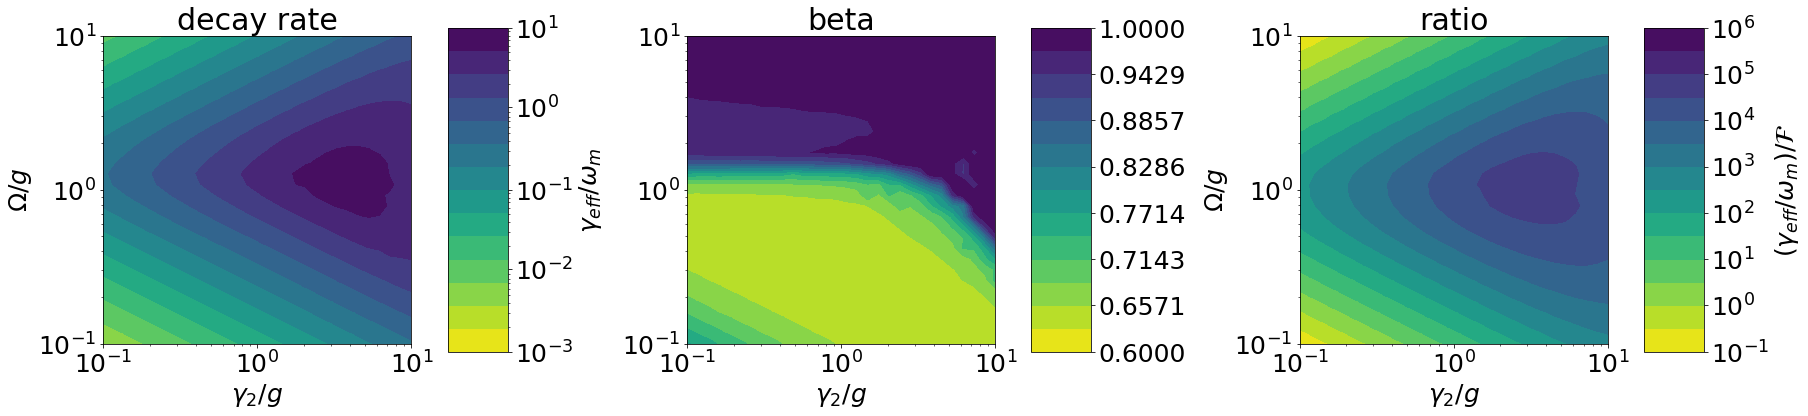

In [11]:
fig = plt.figure(constrained_layout=True)
spec = fig.add_gridspec(ncols=3, nrows=1)

fig.add_subplot(spec[0, 0])
[X,Y] = np.meshgrid(pump/g,T2/g) # define X,Y for contour plot
levels = np.logspace(-3,1,15) # finetune gradation in contour plot
locator = ticker.LogLocator(base=10)
plt.contourf(X,Y, decay_rate/(omega_m), locator=ticker.LogLocator(), levels = levels, cmap = 'viridis_r') # plotting
cbar = plt.colorbar(ticks=locator, aspect = 15, shrink = 0.5)
cbar.ax.tick_params() 
cbar.set_label('$\gamma_{eff}/\omega_m$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\gamma_2/g$')
plt.xticks()
plt.yticks()
plt.ylabel('$\Omega/g$')
plt.title('decay rate')
ax = plt.gca()
ax.set(adjustable='box', aspect='equal')

fig.add_subplot(spec[0, 1])
levels = np.linspace(0.6,1,15) # finetune gradation in contour plot
plt.contourf(X,Y, beta_array, levels = levels, cmap = 'viridis_r') # plotting
cbar = plt.colorbar(aspect = 15, shrink = 0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\gamma_2/g$')
plt.xticks()
plt.yticks()
# plt.ylabel('$\Omega/g$')
plt.title('beta')
ax = plt.gca()
ax.set(adjustable='box', aspect='equal')

fig.add_subplot(spec[0, 2])
levels = np.logspace(-1,6,15) # finetune gradation in contour plot
plt.contourf(X,Y, decay_rate*nth/(omega_m*phonon_ss), locator=ticker.LogLocator(), levels = levels, cmap = 'viridis_r') # plotting
cbar = plt.colorbar(aspect = 15, shrink = 0.5, ticks = locator)
cbar.ax.tick_params()
cbar.set_label('$(\gamma_{eff}/\omega_m)/\mathcal{F}$')
plt.xscale('log')
plt.yscale('log')
plt.xticks()
plt.yticks()
plt.ylabel('$\Omega/g$')
plt.xlabel('$\gamma_2/g$')
plt.title('ratio')
ax = plt.gca()
ax.set(adjustable='box', aspect='equal')
plt.rcParams.update({'font.size': 25})

fig = plt.gcf()
fig.set_size_inches((25, 9))

plt.savefig('decay_QD.png')

### Manuscript Plot

In [2]:
'''
Import data
'''

QD_phonon_decay_thermal = loadmat('./data files/QD_phonon_decay_thermal.mat')

phonon_number_array = QD_phonon_decay_thermal['phonon_number_array']
best_fit_array = QD_phonon_decay_thermal['best_fit_array'][0]
t_final_array = QD_phonon_decay_thermal['t_final_array']
phonon_ss = QD_phonon_decay_thermal['phonon_ss']
decay_rate = QD_phonon_decay_thermal['decay_rate']

pump = QD_phonon_decay_thermal['pump'][0]
T2 = QD_phonon_decay_thermal['T2'][0]
g = int(QD_phonon_decay_thermal['g'])
omega_m = int(QD_phonon_decay_thermal['omega_m'])
nth = int(QD_phonon_decay_thermal['nth'])

In [3]:
'''
Prepare arrays to plot data. Import phonon number arrays, best fit arrays from stored data. Each array is called
through the index tuple (pump, T2): (i,j)
'''

# Phonon_1
i, j = 0, 15
phonon_1 = phonon_number_array[i,j]
phonon_best_fit_1 = best_fit_array[i*30+j][0]
time_1 = np.linspace(0, t_final_array[i,j], 5000)

# Phonon_2
i, j = 19, 15
phonon_2 = phonon_number_array[i,j]
phonon_best_fit_2 = best_fit_array[i*30+j][0]
time_2 = np.linspace(0, t_final_array[i,j], 5000)

# Phonon_3
i, j = 29, 15
phonon_3 = phonon_number_array[i,j]
phonon_best_fit_3 = best_fit_array[i*30+j][0]
time_3 = np.linspace(0, t_final_array[i,j], 5000)

# Phonon_4
i, j = 15, 0
phonon_4 = phonon_number_array[i,j]
phonon_best_fit_4 = best_fit_array[i*30+j][0]
time_4 = np.linspace(0, t_final_array[i,j], 5000)

# Phonon_5
i, j = 15, 19
phonon_5 = phonon_number_array[i,j]
phonon_best_fit_5 = best_fit_array[i*30+j][0]
time_5 = np.linspace(0, t_final_array[i,j], 5000)

# Phonon_6
i, j = 15, 29
phonon_6 = phonon_number_array[i,j]
phonon_best_fit_6 = best_fit_array[i*30+j][0]
time_6 = np.linspace(0, t_final_array[i,j], 5000)

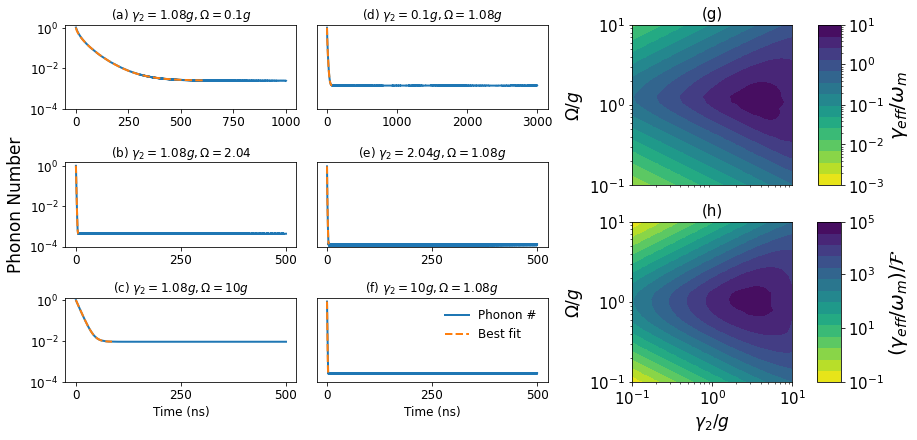

In [4]:
'''
Plot!!
'''

fig = plt.figure(constrained_layout=True)
spec = fig.add_gridspec(ncols=4, nrows=6)

# Set y axis limits
ymax = phonon_1[0] + 1

fig.add_subplot(spec[0:2, 0])
plt.semilogy(time_1, phonon_1, label = 'Phonon #',  linewidth = 2)
plt.semilogy(time_1[:len(phonon_best_fit_1)], phonon_best_fit_1, label = 'Best fit', linestyle = '--', color = '#ff7f0e', linewidth = 2)
plt.title('(a) $\gamma_2 = 1.08g, \Omega = 0.1g$', fontsize = 12)
# legend = plt.legend(fontsize = 10, frameon = False)
plt.xticks([0, 250, 500, 750, 1000], fontsize = 12)
plt.yticks([1, 0.01, 0.0001], fontsize = 12)
plt.ylim(bottom=0.0001)

fig.add_subplot(spec[2:4, 0])
plt.ylabel('Phonon Number', fontsize = 17)
plt.semilogy(time_2, phonon_2, label = 'Phonon #',  linewidth = 2)
plt.semilogy(time_2[:len(phonon_best_fit_2)], phonon_best_fit_2, label = 'Best fit', linestyle = '--', color = '#ff7f0e', linewidth = 2)
plt.title('(b) $\gamma_2 = 1.08g, \Omega = 2.04$', fontsize = 12)
# legend = plt.legend(fontsize = 10, frameon = False)
plt.xticks([0, 250, 500], fontsize = 12)
plt.yticks([1, 0.01, 0.0001], fontsize = 12)
plt.ylim(bottom=0.0001)

fig.add_subplot(spec[4:6, 0])
plt.semilogy(time_3, phonon_3, label = 'Phonon #',  linewidth = 2)
plt.semilogy(time_3[:len(phonon_best_fit_3)], phonon_best_fit_3, label = 'Best fit', linestyle = '--', color = '#ff7f0e', linewidth = 2)
plt.title('(c) $\gamma_2 = 1.08g, \Omega = 10g$', fontsize = 12)
plt.xlabel('Time (ns)', fontsize = 12)
# legend = plt.legend(fontsize = 10, frameon = False)
plt.xticks([0, 250, 500], fontsize = 12)
plt.yticks([1, 0.01, 0.0001], fontsize = 12)
plt.ylim(bottom=0.0001)

fig.add_subplot(spec[0:2, 1])
plt.semilogy(time_4, phonon_4, label = 'Phonon #',  linewidth = 2)
plt.semilogy(time_4[:len(phonon_best_fit_4)], phonon_best_fit_4, label = 'Best fit', linestyle = '--', color = '#ff7f0e', linewidth = 2)
plt.title('(d) $\gamma_2 = 0.1g, \Omega = 1.08g$', fontsize = 12)
plt.xticks([0, 1000, 2000, 3000], fontsize = 12)
plt.yticks([])
plt.ylim(bottom=0.0001)

fig.add_subplot(spec[2:4, 1])
# plt.ylabel('Phonon Number', fontsize = 10)
plt.semilogy(time_5, phonon_5, label = 'Phonon #',  linewidth = 2)
plt.semilogy(time_5[:len(phonon_best_fit_5)], phonon_best_fit_5, label = 'Best fit', linestyle = '--', color = '#ff7f0e', linewidth = 2)
plt.title('(e) $\gamma_2 = 2.04g, \Omega = 1.08g$', fontsize = 12)
# legend = plt.legend(fontsize = 10, frameon = False)
plt.xticks([0, 250, 500], fontsize = 12)
plt.yticks([])
# plt.ylim(top=ymax)
plt.ylim(bottom=0.0001)

fig.add_subplot(spec[4:6, 1])
plt.semilogy(time_6, phonon_6, label = 'Phonon #',  linewidth = 2)
plt.semilogy(time_6[:len(phonon_best_fit_6)], phonon_best_fit_6, label = 'Best fit', linestyle = '--', color = '#ff7f0e', linewidth = 2)
plt.title('(f) $\gamma_2 = 10g, \Omega = 1.08g$', fontsize = 12)
plt.xlabel('Time (ns)', fontsize = 12)
legend = plt.legend(fontsize = 12, frameon = False)
plt.xticks(fontsize = 12)
plt.yticks([])
plt.xticks([0, 250, 500], fontsize = 12)
plt.ylim(bottom=0.0001)

fig.add_subplot(spec[0:3, 2:3])
[X,Y] = np.meshgrid(pump/g,T2/g) # define X,Y for contour plot
levels = np.logspace(-3,1,15) # finetune gradation in contour plot
locator = ticker.LogLocator(base=10)
plt.contourf(X,Y, decay_rate/(omega_m), locator=ticker.LogLocator(), levels = levels, cmap = 'viridis_r') # plotting
cbar = plt.colorbar(ticks=locator, aspect = 18, shrink = 1)
cbar.ax.tick_params(labelsize=15) 
cbar.set_label('$\gamma_{eff}/\omega_m$', fontsize = 20)
plt.xscale('log')
plt.yscale('log')
plt.xticks([])
plt.yticks(fontsize = 15)
plt.ylabel('$\Omega/g$', fontsize = 17)
plt.title('(g)', fontsize = 15)
ax = plt.gca()
ax.set(adjustable='box', aspect='equal')

fig.add_subplot(spec[3:6, 2:3])
levels = np.logspace(-1,5,15) # finetune gradation in contour plot
plt.contourf(X,Y, decay_rate*nth/(omega_m*phonon_ss), locator=ticker.LogLocator(), levels = levels, cmap = 'viridis_r') # plotting
cbar = plt.colorbar(aspect = 18, shrink = 1, ticks = [10**-1, 10, 10**3, 10**5])
cbar.ax.tick_params(labelsize=15)
# cbar.ax.set_yticklabels([0.001, 0.1, 10, 1000])
cbar.set_label('$(\gamma_{eff}/\omega_m)/\mathcal{F}$', fontsize = 20)
plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('$\Omega/g$', fontsize = 17)
plt.xlabel('$\gamma_2/g$', fontsize = 17)
plt.title('(h)', fontsize = 15)
ax = plt.gca()
ax.set(adjustable='box', aspect='equal')
    
fig = plt.gcf()
fig.set_size_inches((16, 6), forward=False)

plt.savefig('QD_decay_combined.png', dpi = 500)